# Weather Model - Linear Models

In [1]:
# libraries
import pandas as pd
import numpy as np
from pyproj import Geod
import json

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import BayesianRidge
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
# connect to data source
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# import preprocessed data
df_path = '/content/drive/MyDrive/CapstoneProject/ryanair_clean_datasets/data_flights_final.csv'
df = pd.read_csv(df_path)

In [4]:
# Drop irrelavant columns
df = df.drop(['FlightID', 'FlightNumber', 'AircraftRegistration', 'ServiceDescription', 'Carrier', 'AOCDescription', 'ScheduledRoute',
              'DepartureScheduled', 'ArrivalScheduled', 'OriginCode', 'DestinationCode', 'OriginLon', 'OriginLat',
                'DestinationLon', 'DestinationLat', 'Point_1_Lat', 'Point_1_Lon','Point_2_Lat', 'Point_2_Lon', 'Point_3_Lat',
                'Point_3_Lon', 'Point_4_Lat', 'Point_4_Lon', 'Point_5_Lat', 'Point_5_Lon','Point_6_Lat', 'Point_6_Lon', 'Point_7_Lat',
                'Point_7_Lon', 'Point_8_Lat', 'Point_8_Lon', 'Point_9_Lat', 'Point_9_Lon','Point_10_Lat', 'Point_10_Lon',
                'WindUMean', 'WindVMean'], axis=1)

In [5]:
df.columns

Index(['AircraftCapacity', 'AircraftTypeGroup', 'BlockTimeScheduled',
       'Burnoff', 'Adults', 'Children', 'Freight', 'Infants', 'Bags',
       'PlannedZeroFuelWeight', 'PlannedTOW', 'PlannedTripTime',
       'TeledyneRampWeight', 'FuelWeight', 'Distance', 'AircraftAge',
       'GeopotentialMean', 'SpecificHumidityMean', 'TemperatureMean',
       'SpecificRainWaterContentMean', 'WindSpeedMean', 'WindDirectionMean'],
      dtype='object')

In [6]:
# Split the data into train and test
X = df.drop(labels=['Burnoff'], axis=1)
y = df['Burnoff']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [7]:
# Define the preprocessor
categorical_columns = ["AircraftTypeGroup"]
numerical_columns = [col for col in X.columns if col not in categorical_columns]

preprocessor = ColumnTransformer(
    transformers=[
        ("categorical", OrdinalEncoder(), categorical_columns),
        ("numerical", StandardScaler(), numerical_columns),
    ]
)

In [8]:
def best_model(X_train, Y_train):
    seed = 21
    folds = 10
    metric = 'neg_mean_squared_error'

    models = {
        "LinearRegression": LinearRegression(),
        "ElasticNet": ElasticNet(),
        "BayesianRidge": BayesianRidge(),
    }

    model_results = []
    model_names = []

    for model_name in models:
        pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', models[model_name])])
        k_fold = KFold(n_splits=folds, random_state=seed, shuffle=True)
        results = cross_val_score(pipeline, X_train, Y_train, cv=k_fold, scoring=metric)
        rmse_results = np.sqrt(-results)

        model_results.append(rmse_results)
        model_names.append(model_name)

        print(f"{model_name:>20}: {rmse_results.mean():.2f} ({rmse_results.std():.2f})")

    figure = plt.figure()
    figure.suptitle('Regression Models Comparison with Preprocessing')
    ax = figure.add_subplot(111)
    plt.boxplot(model_results)
    ax.set_xticklabels(model_names, rotation=45, ha="right")
    ax.set_ylabel("RMSE")
    plt.margins(0.05, 0.1)
    plt.show()

    LinearRegression: 241.05 (5.11)
          ElasticNet: 369.62 (6.40)
       BayesianRidge: 241.05 (5.11)


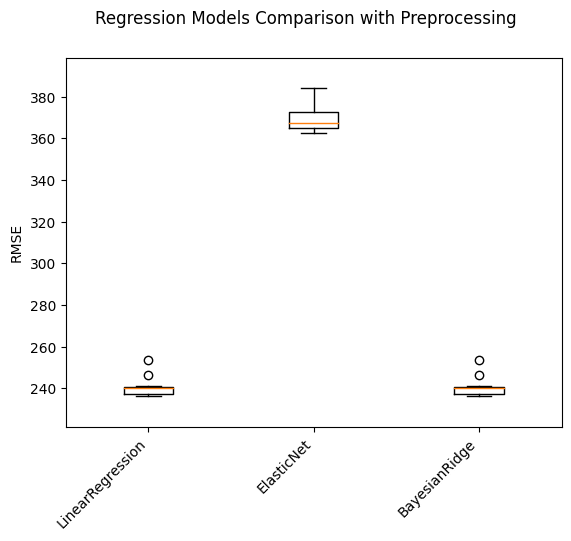

In [9]:
best_model(X_train, y_train)

## Best Performer: BayesianRidge

In [10]:
br_regressor = BayesianRidge()

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('br_regressor', br_regressor)])

pipeline.fit(X_train, y_train)

# Predict on the test data
y_pred = pipeline.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse:.2f}")

mae = mean_absolute_error(y_test, y_pred)
print(f"Test MAE: {mae:.2f}")

r2 = r2_score(y_test, y_pred)
print(f"Test R^2: {r2:.2f}")

Test RMSE: 235.96
Test MAE: 174.94
Test R^2: 0.98


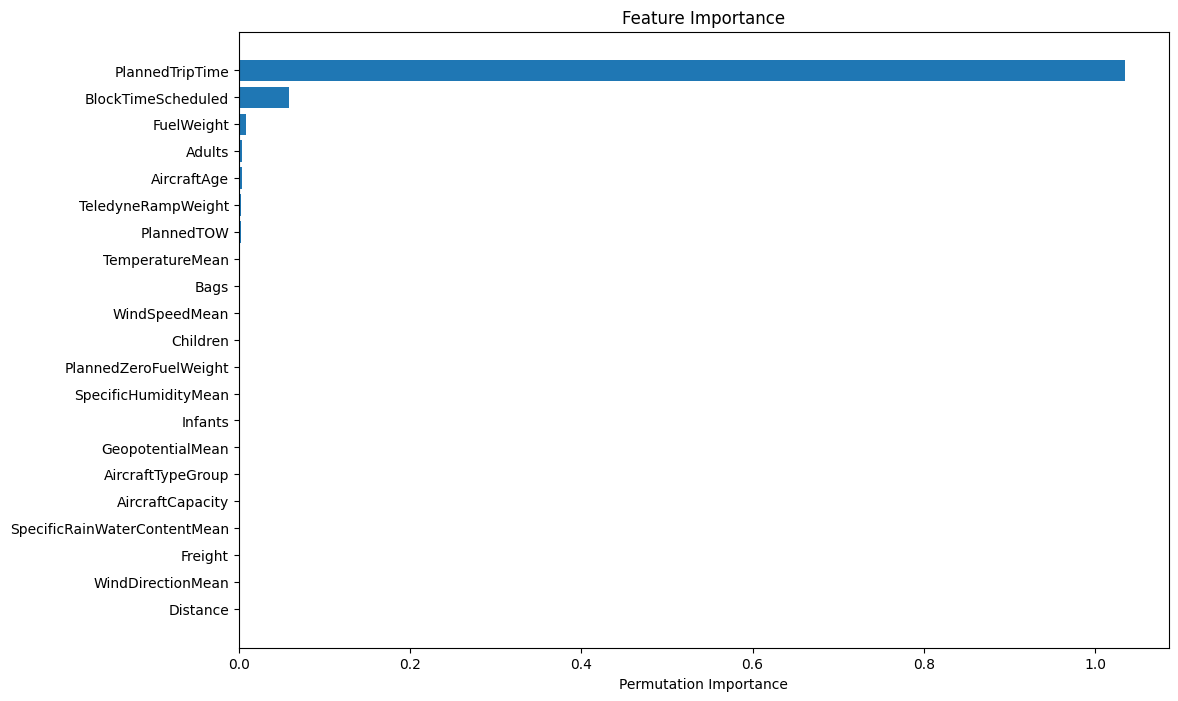

In [11]:
perm_importance = permutation_importance(pipeline, X_test, y_test)
sorted_idx = perm_importance.importances_mean.argsort()

# Plot
plt.figure(figsize=(12, 8))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.xlabel('Permutation Importance')
plt.title('Feature Importance')
plt.show()

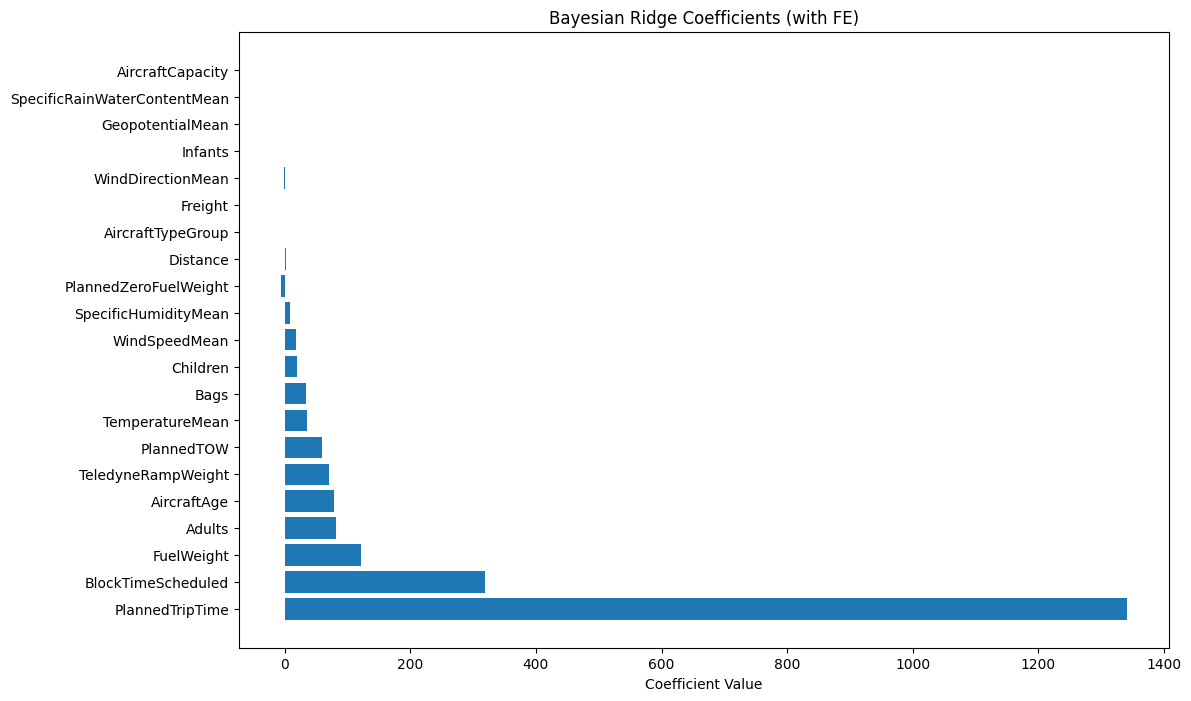

In [12]:
# Extract the BayesianRidge regressor from the pipeline
br_regressor = pipeline.named_steps['br_regressor']

# Get the coefficients from the BayesianRidge model
coefficients = br_regressor.coef_
features = X_train.columns

# Sort coefficients and features by the magnitude of the coefficients
sorted_indices = np.argsort(np.abs(coefficients))[::-1]

# Plot
plt.figure(figsize=(12, 8))
plt.barh(range(len(sorted_indices)), coefficients[sorted_indices], align='center')
plt.yticks(range(len(sorted_indices)), features[sorted_indices])
plt.xlabel('Coefficient Value')
plt.title('Bayesian Ridge Coefficients (with FE)')
plt.show()

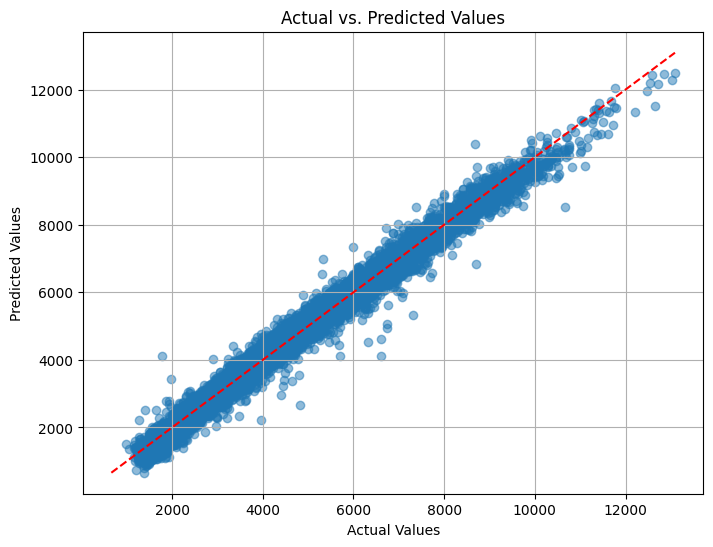

In [13]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)  # Plotting actual vs. predicted values
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# Plotting the identity line for reference
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--')  # Red dashed line

plt.grid(True)
plt.show()

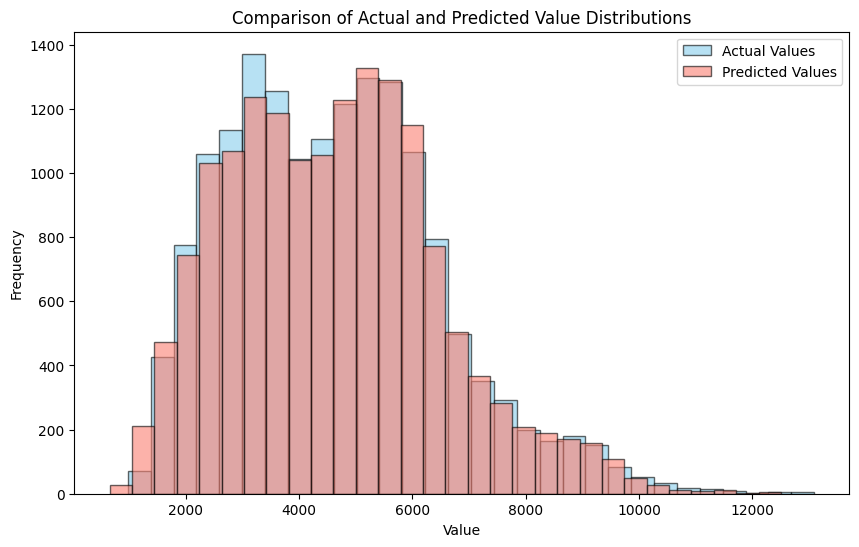

In [14]:
plt.figure(figsize=(10, 6))

plt.hist(y_test, bins=30, alpha=0.6, label='Actual Values', color='skyblue', edgecolor='black')
plt.hist(y_pred, bins=30, alpha=0.6, label='Predicted Values', color='salmon', edgecolor='black')

plt.title('Comparison of Actual and Predicted Value Distributions')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend(loc='upper right')

plt.show()